In [1]:
import os
import pickle
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import tensorflow as tf


In [2]:
# Import the drive module from the google.colab library.
from google.colab import drive
# Mount Google Drive at the specified mount point (/content/drive).through which the notebook to access the contents of your Google Drive.
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Check if GPU is available
if tf.test.is_gpu_available():
    print("GPU is available. Using GPU for training.")
else:
    print("GPU is not available. Using CPU for training.")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU is available. Using GPU for training.


In [5]:
!unzip /content/drive/MyDrive/UB/DLProject/archive.zip -d /content/archive

Streaming output truncated to the last 5000 lines.
  inflating: /content/archive/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/archive/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/archive/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/archive/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/archive/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/archive/Images/2846037553_1a1de50709.jpg  
  inflating: /content/archive/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/archive/Images/2846843520_b0e6211478.jpg  
  inflating: /content/archive/Images/2847514745_9a35493023.jpg  
  inflating: /content/archive/Images/2847615962_c330bded6e.jpg  
  inflating: /content/archive/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/archive/Images/2848266893_9693c66275.jpg  
  inflating: /content/archive/Images/2848571082_26454cb981.jpg  
  inflating: /content/archive/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/archive/Images/28

In [6]:
datasetFolder = '/content/archive/Images'
captionsFolder = '/content/archive/captions.txt'

In [7]:

# Load pre-trained VGG16 model
modelVGG = VGG16()

# Creating a new model by removing softmax layer from VGG16 which outputs the features extracted by VGG16 instead of predictions
modelVGG = Model(inputs=modelVGG.inputs, outputs=modelVGG.layers[-2].output)

# Printing the summary of the modified model
print(modelVGG.summary())


553467096/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [8]:
#reading the images
import cv2
total_images_count = 0
image_dimensions_list = []
imagePaths = []
for image_filename in os.listdir(datasetFolder):
  image_full_path = os.path.join(datasetFolder, image_filename)
  image_data = cv2.imread(image_full_path) #reading the image inside the file
  if image_data is not None:
    imagePaths.append(image_full_path)
    image_height, image_width, _ = image_data.shape
    #getting image dimensions and storing the
    image_dimensions_list.append((image_height, image_width))
    total_images_count += 1

# Printing the statistics of the dataset that we are working with
print("Total samples:", total_images_count)
image_dimensions_list = np.array(image_dimensions_list)
average_dimensions = np.mean(image_dimensions_list, axis=0)
minimum_dimensions = np.min(image_dimensions_list, axis=0)
maximum_dimensions = np.max(image_dimensions_list, axis=0)

print("\nImage size statistics:")
print("Average size:", average_dimensions)
print("Minimum size:", minimum_dimensions)
print("Maximum size:", maximum_dimensions)

Total samples: 8091

Image size statistics:
Average size: [397.25188481 457.87220368]
Minimum size: [127 164]
Maximum size: [500 500]


In [9]:
print(imagePaths[:5])

['/content/archive/Images/3585495069_33cba06d0a.jpg', '/content/archive/Images/3522749949_fb615cee47.jpg', '/content/archive/Images/3064716525_b8418d4946.jpg', '/content/archive/Images/2616009069_82561da2e5.jpg', '/content/archive/Images/3373069977_bc73e9e409.jpg']


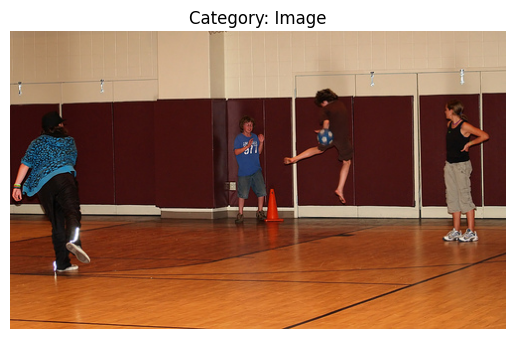

In [10]:
import matplotlib.pyplot as plt

imageData = cv2.imread(imagePaths[0])

# Checking if the image was loaded successfully
if imageData is not None:
    # Convert the image from BGR to RGB format for display using matplotlib
    RGBimage = cv2.cvtColor(imageData, cv2.COLOR_BGR2RGB)
    # Display the image using matplotlib
    plt.imshow(RGBimage)

    # title
    plt.title("Category: Image")
    plt.axis('off')
    # display the plot
    plt.show()


In [11]:
# Initialize an empty dictionary to store extracted_features extracted from images
extracted_features = {}

images_directory = datasetFolder

# Looping through each image name in the dataset directory
for imageFilename in os.listdir(images_directory):
    # Construct the full path to the image file
    image_full_path = os.path.join(images_directory, imageFilename)
    # Load the image with a target size of 224x224 pixels
    img = load_img(image_full_path, target_size=(224, 224))
    # Convert the image to a numpy array
    img = img_to_array(img)
    # Restructure the array to include a new dimension (pertaining to the batch size).
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)

    # Use the learned model to predict the image's characteristics without using any words.
    extracted_feature = modelVGG.predict(img, verbose=0)
    # Extracting the image ID
    imgID = imageFilename.split('.')[0]
    # Using the picture ID as the key, record the extracted characteristics in the dictionary.
    extracted_features[imgID] = extracted_feature

# The extracted features for each picture in the dataset are now stored in the `features` dictionary,
#where the feature vector is the value and the image ID is the key.


In [12]:
import pickle

# Store features as a pickle file
with open('sbonthu_kvayalpa_mballa.pkl', 'wb') as f:
    pickle.dump(extracted_features, f)

# Features are loaded from the pickle file.
with open('sbonthu_kvayalpa_mballa.pkl', 'rb') as f:
    extracted_features = pickle.load(f)

# In read mode, open the captions file.
with open(captionsFolder, 'r') as f:
    # If the first line is a header, ignore it.
    next(f)
    # Read the remaining content of the file
    captionsDOC = f.read()


In [13]:
# Initialize an empty dictionary to store mappings between image IDs and captions
id_to_captions = {}

# Iterate through each line in the captions document
for caption_line in captionsDOC.split('\n'):
    # split the picture ID and caption, split the line between commas.
    caption_parts = caption_line.split(',')
    # skipping lines containing less than two caption_parts (invalid picture ID and caption combination).
    if len(caption_line) < 2:
        continue
    # Extract the image ID and caption from the tokens
    image_id, caption = caption_parts[0], caption_parts[1:]
    # Remove the file extension from the image ID
    image_id = image_id.split('.')[0]
    # Join the caption tokens into a single string
    caption = " ".join(caption)
    # Check if the image ID is already in the mapping dictionary
    if image_id not in id_to_captions:
        # If not, initialize an empty list for the captions associated with this image ID
        id_to_captions[image_id] = []
    # Append the caption to the list of captions for this image ID
    id_to_captions[image_id].append(caption)


In [15]:
len(id_to_captions)

8091

In [14]:
import string
# Cleaning captions
def clean(id_to_captions):
    # iteration over each key-value pair in the mapping
    for key, captions in id_to_captions.items():
        # iterate over each caption in the captions list
        for i in range(len(captions)):
            image_caption = captions[i]
            # converting the caption to lowercase
            image_caption = image_caption.lower()
            # removing special characters in the captions
            image_caption = image_caption.replace('[^A-Za-z]', '')
            # removing extra white spaces
            image_caption = image_caption.replace('\s+', ' ')
            # adding start and end tokens
            image_caption = 'startseq ' + " ".join([word for word in image_caption.split() if len(word)>1]) + ' endseq'
            # assigning the modified caption back to the list
            captions[i] = image_caption


In [16]:
clean(id_to_captions)


In [17]:
id_to_captions['1000268201_693b08cb0e']


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [18]:
#  For storing all captions empty list is initialised
all_captions = []

for key in id_to_captions:
    # Iteration through every caption related to the current key
    for cap in id_to_captions[key]:
        # Appending the caption to the captions list
        all_captions.append(cap)


In [19]:
len(all_captions)

40455

In [20]:
# Initialize a Tokenizer object
caption_tokenizer = Tokenizer()
# To create the vocabulary, apply the tokenizer to every caption.
caption_tokenizer.fit_on_texts(all_captions)

#Counting the number of distinct words to determine the vocabulary size.
vocab_size = len(caption_tokenizer.word_index) + 1  # Add 1 for the reserved index 0
# Printing the vocabulary size
print(vocab_size)

# Determine the dataset's maximum caption length (word count).
max_length = max(len(caption.split()) for caption in all_captions)
# Printing the maximum length
print(max_length)


8485
35


In [21]:
# Obtain a list from the mapping dictionary containing image IDs.
image_ids = list(id_to_captions.keys())
# Calculating the index to split the data into training and testing sets (90% training, 10% testing)
split = int(len(image_ids) * 0.90)
train = image_ids[:split]  # 90% of the data for training
test = image_ids[split:]   # 10% of the data for testing


In [22]:
def data_generator(image_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Creating initial lists to hold input sequences, output sequences, and picture features.
    X1, X2, y = list(), list(), list()
    # Set up a counter to record the total number of samples produced.
    n = 0
    while 1:
        # Iterate through each key in the data keys
        for key in image_keys:
            n += 1
            # Get the captions that go with the current key.
            captions = mapping[key]
            # Iteration through each caption
            for caption in captions:
                #Use tokenizer to convert caption to integer series
                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    # Split the sequence into input and output sequences
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad input sequence to max_length
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # Convert output sequence to one-hot encoding
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Add the input sequence, output sequence, and image features to the lists.
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                # Convert lists to numpy arrays
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                # Yield the batch of data
                yield (X1, X2), y
                # Reset the counter and lists for the following batch.
                X1, X2, y = list(), list(), list()
                n = 0


In [ ]:
# # Define the shape (4096,) of the input layer for the image features.
# image_feature_input = Input(shape=(4096,))
# # Dropout regularization should be applied to the provided image features.
# image_feature_dropout = Dropout(0.4)(image_feature_input)
# # Use the ReLU activation function and a fully linked layer with 256 units applied.
# image_feature_dense = Dense(256, activation='relu')(image_feature_dropout)

# #Using shape (max_length,) define the input layer for sequence features.
# sequence_input = Input(shape=(max_length,))
# # Utilize word embedding with embedding dimension 256 and vocabulary size vocab_size, and mask zero padding.
# sequence_embedding = Embedding(vocab_size, 256, mask_zero=True)(sequence_input)
# # Put the word embeddings via dropout regularization.
# sequence_dropout = Dropout(0.4)(sequence_embedding)
# # Utilize a 256-unit LSTM layer to process the sequence features.
# sequence_lstm = LSTM(256)(sequence_dropout)

# # combine the picture's output and feature processing sequence
# combined_features = add([image_feature_dense, sequence_lstm])
# # Utilizing a fully linked layer with ReLU activation function and 256 units.
# combined_dense = Dense(256, activation='relu')(combined_features)
# # Use a softmax activation function to determine the probability of the output throughout the vocabulary.
# outputs = Dense(vocab_size, activation='softmax')(combined_dense)

# model = Model(inputs=[image_feature_input, sequence_input], outputs=outputs)
# # Use the Adam optimizer with categorical cross-entropy loss to compile the model.
# model.compile(loss='categorical_crossentropy', optimizer='adam')


In [24]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Concatenate, Dot, Reshape
from keras.models import Model
from keras.optimizers import Adam
import keras.backend as K

# Define the shape (4096,) of the input layer for the image features.
image_feature_input = Input(shape=(4096,))
# Dropout regularization should be applied to the provided image features.
image_feature_dropout = Dropout(0.4)(image_feature_input)
# Use the ReLU activation function and a fully linked layer with 256 units applied.
image_feature_dense = Dense(256, activation='relu')(image_feature_dropout)

# Using shape (max_length,) define the input layer for sequence features.
sequence_input = Input(shape=(max_length,))
# Utilize word embedding with embedding dimension 256 and vocabulary size vocab_size, and mask zero padding.
sequence_embedding = Embedding(vocab_size, 256, mask_zero=True)(sequence_input)
# Put the word embeddings via dropout regularization.
sequence_dropout = Dropout(0.4)(sequence_embedding)
# Utilize a 256-unit LSTM layer to process the sequence features.
sequence_lstm = LSTM(256, return_sequences=True)(sequence_dropout)

# Attention Mechanism
# Compute attention scores
attention_scores = Dot(axes=-1)([sequence_lstm, image_feature_dense])
attention_scores = Reshape((max_length,))(attention_scores)  # Reshape for compatibility

# Softmax activation to obtain attention weights
attention_weights = Activation('softmax')(attention_scores)
attention_weights = Reshape((max_length, 1))(attention_weights)  # Reshape for compatibility

# Weighted sum of image features based on attention scores
context_vector = Dot(axes=1)([attention_weights, sequence_lstm])
context_vector = Reshape((256,))(context_vector)  # Reshape for compatibility

# Concatenate context vector with image feature
combined_features = Concatenate()([context_vector, image_feature_dense])

# Utilizing a fully linked layer with ReLU activation function and 256 units.
combined_dense = Dense(256, activation='relu')(combined_features)
# Use a softmax activation function to determine the probability of the output throughout the vocabulary.
outputs = Dense(vocab_size, activation='softmax')(combined_dense)

model = Model(inputs=[image_feature_input, sequence_input], outputs=outputs)
# Use the Adam optimizer with categorical cross-entropy loss to compile the model.
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 35, 256)              2172160   ['input_5[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 dropout_3 (Dropout)         (None, 35, 256)              0         ['embedding_1[0][0]']         
                                                                                            

In [25]:
epochs = 5
batch_size = 32
# Divide the total number of training samples by the batch size to determine the number of steps per epoch.
steps = len(train) // batch_size

for i in range(epochs):
    # Create a data generator to generate batches of training data
    generator = data_generator(train, id_to_captions, extracted_features, caption_tokenizer, max_length, vocab_size, batch_size)

    # Train the model for one epoch using the generated batches
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


227/227 [==============================] - 58s 256ms/step - loss: 3.2749


In [26]:
model.save('image2textVGGLSTMModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
# This function uses the tokenizer's vocabulary to turn a numerical index back to a word.
#It requires two parameters: "tokenizer," which is the tokenizer object holding the vocabulary, and "integer," which is the number index to convert.
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        # Check if the current index matches the provided integer.
        if index == integer:
            # If a match is found, return the corresponding word.
            return word
   # Return None if an index that matches is not found. This shows that there was no term in the tokenizer's vocabulary that the number matched.
    return None


In [28]:
# Define the function predict_caption, which produces an image's caption. The trained model,
#a picture, a tokenizer, and the longest possible caption are the four parameters required.
def predict_caption(model, image, tokenizer, max_length):
   # Initialize the start sequence token in the caption.
    current_caption = 'startseq'

   # Starting a loop that iteratively creates each word in the caption up to the maximum length.
    for i in range(max_length):
        # Use the tokenizer to turn the current caption into an integer sequence. The tokenizer converts
        #every word in a preset vocabulary into the matching number.
        sequence = tokenizer.texts_to_sequences([current_caption])[0]

    #To ensure that the sequence has a fixed length that matches the longest possible caption, pad it.
    #The model requires input sequences to have a constant length, hence this is required.
        sequence = pad_sequences([sequence], maxlen=max_length)

        # Use the model to predict the caption's following word.The input for the model consists of the current image.
        #the words that have been created thus far. For cleaner execution, the prediction process's output is suppressed when'verbose=0' is set.
        predicted_index = model.predict([image, sequence], verbose=0)

        #Generate an actual word index from the model's prediction, which is a probability distribution across the vocabulary.
        # The most likely word's index is utilized.
        predicted_index = np.argmax(predicted_index)

        # To turn it back into a word, the expected word index in the tokenizer.
        #This function transfers words to integer indices; it is probably defined somewhere else.
        word = idx_to_word(predicted_index, tokenizer)

        if word is None:
            break

        # The anticipated word should be added to the existing caption text and separated with a space.
        current_caption += " " + word

       #stop the loop if the expected word is the end sequence token. This denotes the caption's conclusion.
        if word == 'endseq':
            break

    return current_caption


In [29]:
# The BLEU score, which is a measure of text similarity, is determined using the corpus_bleu function.
from nltk.translate.bleu_score import corpus_bleu

# Set up two empty lists to store the projected and real captions.
actual, predicted = list(), list()

# Iterate over every key in the dataset "test." It is expected that "test"
#is a dictionary or a collection of IDs for the photos in the test set.
for key in test:
    # Get the list of real captions from a "mapping" dictionary for the picture that is now shown.
    #"Mapping" need to be a dictionary with a list of captions as the associated value for each key, which is an image ID.
    captions = id_to_captions[key]

    #Create a caption prediction for the currently seen image by utilizing the preset function 'predict_caption'.
    #The model, the maximum caption length, a tokenizer, and the extracted features for the current picture are the inputs for this function.
    y_pred = predict_caption(model, extracted_features[key], caption_tokenizer, max_length)

    #Dividing each real caption into a word list.
    caption_words_list = [caption.split() for caption in captions]

    # Dividing the anticipated caption into a phrase list.
    y_pred = y_pred.split()

    # Add the list of anticipated captions and the list of actual captions to the corresponding lists.
    actual.append(caption_words_list)
    predicted.append(y_pred)

#Computeing the 1-gram and 2-gram BLEU scores. The expected and actual captions are compared to determine the BLEU scores.
#The significance of matching n-grams of various lengths is determined by "weights." While BLEU-2 takes into account both
#single words and pairs of successive words, BLEU-1 concentrates on the matching of individual words.

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))  # evaluation metric for single words.
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))  # evaluation metric for both single words and pairs.
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))  # evaluation metric for trigrams.
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))  # evaluation metric for quadgrams.

BLEU-1: 0.582260
BLEU-2: 0.349722
BLEU-3: 0.222629
BLEU-4: 0.134580


In [30]:
# import the Image class from the PIL package.
from PIL import Image
# To plot photos, import the pyplot module from matplotlib as plt.
import matplotlib.pyplot as plt

# Define the 'generate_caption' function, which accepts an image name as input.
def generate_caption(image_name):
    # To isolate the picture ID, split the image_name by '.' and obtain the first portion. It is assumed that the format of the picture name is 'ID.extension'.
    image_id = image_name.split('.')[0]

    #Use 'os.path.join(datasetFolder, image_name)' to open the image file from a provided path. This will create the whole path by combining.
    # The picture name and the folder location for the dataset. To do this, the 'os' module and the variable 'datasetFolder' need to be declared outside to this function.
    image = Image.open(os.path.join(datasetFolder, image_name))

   #Obtain captions from a mapping dictionary for the specified picture ID.
   #The dictionary "mapping," whose values are lists of captions and whose keys are picture IDs, must be created outside of this function.
    captions = id_to_captions[image_id]

    # Print the actual captions associated with the image.
    print('==================Actual captions==================')
    for caption in captions:
        print(caption)

    # A model, feature extractor, tokenize, and maximum caption length set outside of the function are used to generate
    #the predicted caption for the picture. It is also necessary to define the 'predict_caption' function somewhere else.
    y_pred = predict_caption(model, extracted_features[image_id], caption_tokenizer, max_length)

    # Print the predicted caption.
    print('==================Predicted Caption==================')
    print(y_pred)

    # Display the image using matplotlib's imshow function.
    plt.imshow(image)


==================Actual captions==================
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
==================Predicted Caption==================
startseq the woman is sitting in the middle of the rainbow tent endseq


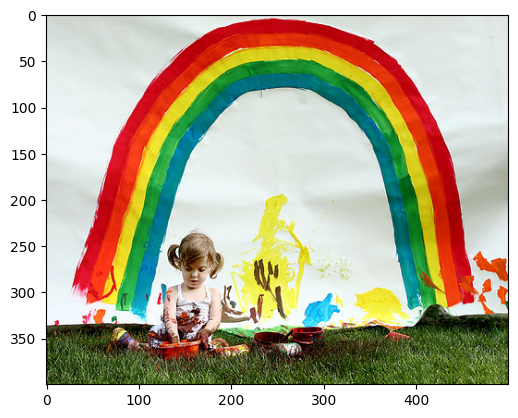

In [31]:
generate_caption('1002674143_1b742ab4b8.jpg')


==================Actual captions==================
startseq woman dressed in blue jacket and blue jeans rides brown horse near frozen lake and snow-covered mountain endseq
startseq woman in blue jacket rides brown pony near water endseq
startseq woman rides horse near frozen lake in the wintertime endseq
startseq young blond woman sitting atop brown draft horse in the snowy mountains endseq
startseq woman blue jacket sits on daft horse near frozen lake endseq
==================Predicted Caption==================
startseq dog is walking through the snow endseq


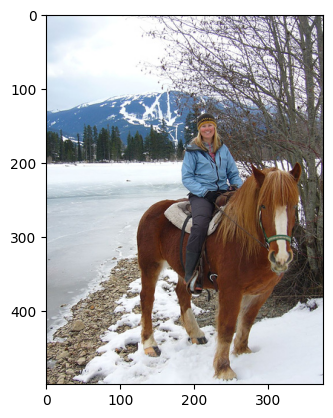

In [32]:
generate_caption('109202756_b97fcdc62c.jpg')

==================Actual captions==================
startseq lone climber on snowcapped mountain with several huge mountains in the background endseq
startseq man is standing looking at the path ahead while hiking in mountain range endseq
startseq man on top of mountain looks at the mountains surrounding him endseq
startseq person with backpack stands on snowy mountain endseq
startseq sole mountain climber stands atop snowy peak looking left endseq
==================Predicted Caption==================
startseq two hikers are walking down snowy snow endseq


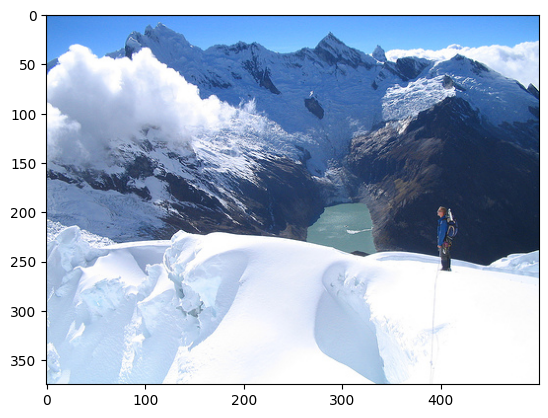

In [33]:
generate_caption('56494233_1824005879.jpg')